# Introduction

In this phase of my final project I will be conducting the data preprocessing, EDA, and A/B testing necessary to solve the task **Assess the performance of the chain's sales outlets**. This notebook will follow the outline described in the Decomposition portion of my final project. 

# Links

**presentation:** https://drive.google.com/file/d/1m8PPZv8FPmfh4ypeJxvI3SU6TU5UbKec/view?usp=sharing

**dashboard:** https://public.tableau.com/app/profile/annabelle.petrichor/viz/final_project_dashboard_16789833577320/final_project_dashboard?publish=yes

## Initialization

In [1]:
# importing necessary libraries

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st

In [2]:
# importing the retail dataset with a try/except clause

try: 
    retail_data = pd.read_csv('datasets/retail_dataset_us.csv')
                       
except:
    retail_data = pd.read_csv('/datasets/retail_dataset_us.csv')
    
retail_data.head()

# importing the retail dataset with a try/except clause

try: 
    product_data = pd.read_csv('datasets/product_codes_us.csv', sep = ';')
                       
except:
    product_data = pd.read_csv('/datasets/product_codes_us.csv', sep = ';')
    
product_data.head()

retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   loyalty_program  105335 non-null  int64  
 6   ShopID           105335 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 5.6+ MB


### description of `retail_data`

- `purchaseId`
- `item_ID`
- `purchasedate`
- `Quantity` — the number of items in the purchase
- `CustomerID`
- `ShopID`
- `loyalty_program` — whether the customer is a member of the loyalty program

product_data.info()

### description of `product_data`

- `productID`
- `price_per_one`

## Data Preprocessing

In [3]:
# fix datatype in `purchasedate`

retail_data['purchasedate'] = pd.to_datetime(
    retail_data['purchasedate'], format = '%Y-%m-%d %H:%M:%S'
)

In [4]:
# converting all column names in to snake_case for easier analysis

retail_data = retail_data.rename(
    columns={
        "purchaseid": "purchase_id", 
        "item_ID": "item_id", 
        'Quantity':'quantity', 
        'purchasedate':'purchase_date', 
        'CustomerID': 'customer_id', 
        'loyalty_program':'loyalty_program',
        'ShopID':'shop_id'
    }
)

product_data = product_data.rename(
    columns={
        "productID": "product_id", 
        "price_per_one": "price_per_one",
    }
)

In [5]:
# examine how many of the NUll values in `customer_id` are in `loyalty_program`

retail_data[retail_data['customer_id'].isnull()].groupby(['loyalty_program']).count()

# check the total number of of the `customer_id` column that is NULL values

len(retail_data[retail_data['customer_id'].isnull()])

(
    len(retail_data[retail_data['customer_id'].isnull()]) / len(retail_data)
) * 100

34.37603835382352

#### Null Value Notes

Given that all the null values in `customer_id` is the same as the '0s' in `loyalty_program` we can infer that all the customers with no ID numbers are not members of the loyalty program. Thus, I will fill the null values with '0' to make later analysis clear.

In [6]:
# filling the Null values in `customer_id` with "non-member"

retail_data['customer_id'] = retail_data['customer_id'].fillna(0)

retail_data['customer_id'].value_counts()

retail_data.info()

retail_data['customer_id'] = retail_data['customer_id'].astype('int64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105335 non-null  object        
 1   item_id          105335 non-null  object        
 2   quantity         105335 non-null  int64         
 3   purchase_date    105335 non-null  datetime64[ns]
 4   customer_id      105335 non-null  float64       
 5   loyalty_program  105335 non-null  int64         
 6   shop_id          105335 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.6+ MB


## EDA

### Starting Hypotheses:

1: Shops with higher loyalty program utilizations will have higher sales

2: Customers who are part of the loyalty program make more total purchases

3: Customers who are part of the loyalty program have larger purchase totals

In [7]:
# changing `product_id` to `item_id` to merge dfs

product_data.columns = ['item_id', 'price_per_one']

In [8]:
# merging dfs on `item_id`

retail_merge = pd.merge(retail_data, product_data, on = ['item_id'])

retail_merge.info()

retail_merge.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105335 entries, 0 to 105334
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105335 non-null  object        
 1   item_id          105335 non-null  object        
 2   quantity         105335 non-null  int64         
 3   purchase_date    105335 non-null  datetime64[ns]
 4   customer_id      105335 non-null  int64         
 5   loyalty_program  105335 non-null  int64         
 6   shop_id          105335 non-null  object        
 7   price_per_one    105335 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 7.2+ MB


,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427,0,Shop 3,0.42
1,541104,21873,0,2017-01-13 14:29:00,0,0,Shop 0,0.42
2,540418,21873,1,2017-01-07 11:04:00,0,0,Shop 0,0.42
3,541516,21873,2,2017-01-18 17:34:00,0,0,Shop 0,0.42
4,541566,21873,35,2017-01-19 11:50:00,23401,1,Shop 22,0.42


In [9]:
# creating a `total_price` column

retail_merge['total_price'] = retail_merge['quantity'] * retail_merge['price_per_one']

retail_merge.head()

retail_data['item_id'].value_counts()

retail_merge['item_id'].value_counts()

85123A      565
22423       499
22469       414
22720       377
85099B      372
           ... 
DCGS0072      1
22125         1
84977         1
84964B        1
79320         1
Name: item_id, Length: 3159, dtype: int64

### `retail_merge` notes

After renaming the `product_id` column to `item_id` in the `product_data` df I merged it with `retail_data` on the `item_id` column. I then ran value_counts() on the `item_id` column for both the original `retail_data` df and the new `retail_merge` df. The value_counts() call showed no change to the `item_id` column after merging, which means I can progress with my analysis. 

Text(0, 0.5, 'Total Sales')

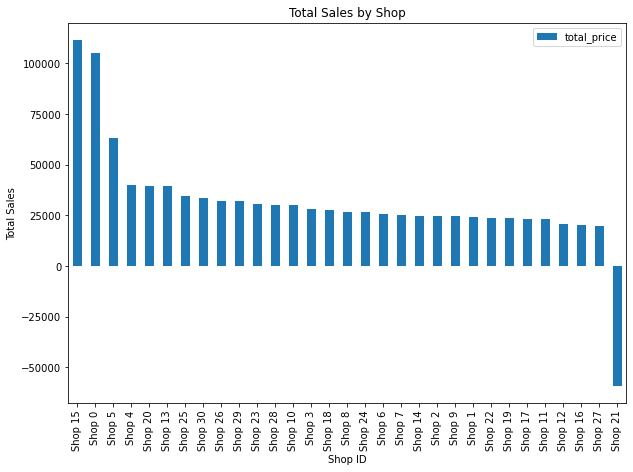

In [10]:
shop_pivot = retail_merge.pivot_table(
    index = 'shop_id',
    values = 'total_price',
    aggfunc = 'sum'
).reset_index().sort_values(by = 'total_price', ascending = False)

shop_pivot.head()

shop_pivot.plot(kind = 'bar', x = 'shop_id', y = 'total_price', figsize = (10,7))
plt.title('Total Sales by Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales')

### Total Sales by Shop Notes

There appears to be an error in the data for Shop 21 where their total sales are recorded as negative. To solve this error I will drop all rows in `total_price` less than -1

In [11]:
# checking `retail_merge` where quantity is less than 0

retail_merge[retail_merge['quantity'] < 0].head(5)

,purchase_id,item_id,quantity,purchase_date,customer_id,loyalty_program,shop_id,price_per_one,total_price
49,C542537,22195,-2,2017-01-28 13:54:00,18180,0,Shop 14,1.65,-3.30
349,C540250,79321,-2,2017-01-05 16:02:00,23190,1,Shop 7,0.00,-0.00
446,C540417,79321,-73,2017-01-07 10:56:00,19359,0,Shop 9,0.00,-0.00
678,C542078,22189,-2,2017-01-25 12:11:00,18533,0,Shop 7,2.31,-4.62
735,C542792,22891,-2,2017-02-01 10:49:00,20306,0,Shop 14,3.75,-7.50


In [12]:
# creating returns df

retail_merge_returns = retail_merge[retail_merge['total_price'] < 0]
retail_merge_returns.head()

returns_pivot = retail_merge_returns.pivot_table(
    index = 'shop_id',
    values = 'total_price',
    aggfunc = 'sum'
).reset_index().sort_values(by = 'total_price', ascending = False)

returns_pivot.head()

,shop_id,total_price
13,Shop 20,-363.79
23,Shop 3,-382.87
26,Shop 5,-411.12
18,Shop 25,-415.99
19,Shop 26,-496.89


(Text(0, 0.5, 'Total Sales'),)

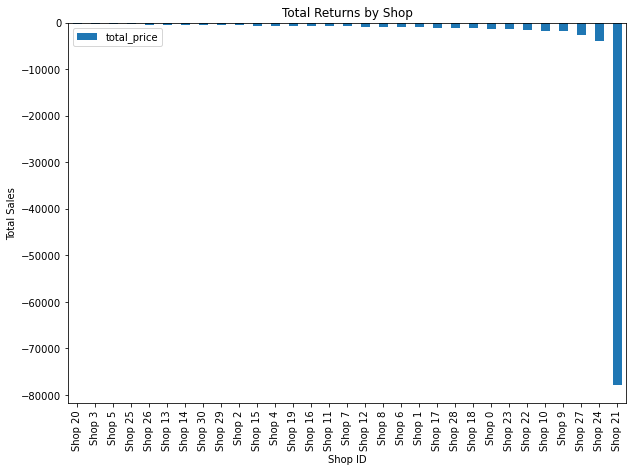

In [13]:
# graphing total returns by shop id

returns_pivot.plot(kind = 'bar', x = 'shop_id', y = 'total_price', figsize = (10,7))
plt.title('Total Returns by Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales'),

### Negative Quantity Notes

We can infer from the prevelence of negative quantities in the dataset that these transactions are likely returns. While this information is useful, it impeeds analysis of purchases and so I will remove all rows with negative values in 'total_price'.

Most shops have very low numbers of negative revenues, with the exception of Shop 21 which has nearly 80K recorded. This requires further external investigation to determine where this data collection issue lies. 

retail_merge = retail_merge[retail_merge['total_price'] > -1]

retail_merge.info()

In [14]:
# redo the shop_pivot

shop_pivotv2 = retail_merge.pivot_table(
    index = 'shop_id',
    values = 'total_price',
    aggfunc = 'sum'
).reset_index().sort_values(by = 'total_price', ascending = False)

shop_pivotv2.head()

,shop_id,total_price
7,Shop 15,111594.68
0,Shop 0,105236.50
26,Shop 5,63095.79
25,Shop 4,39782.97
13,Shop 20,39536.41


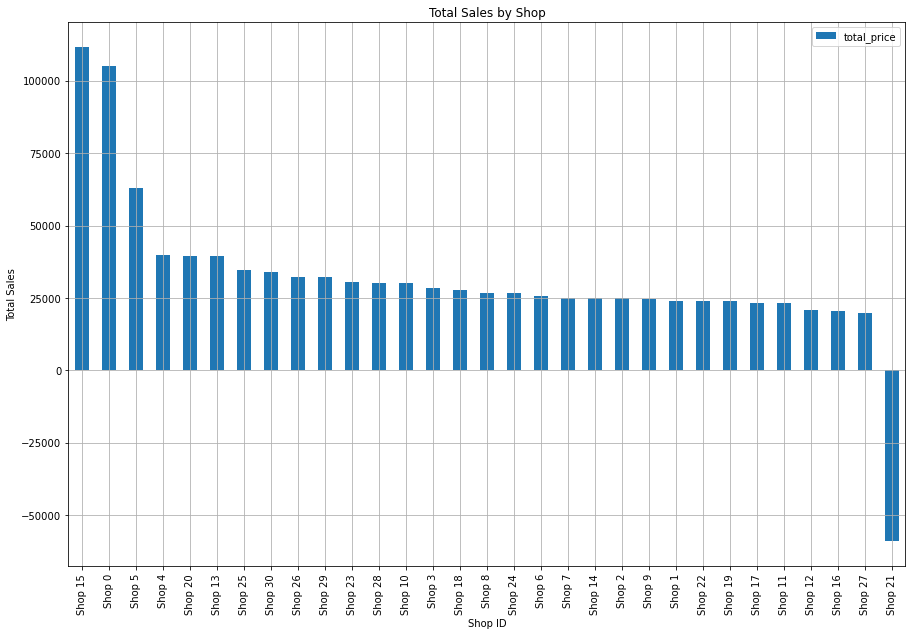

In [15]:
# regraph Total Sales by Shop

shop_pivotv2.plot(kind = 'bar', x = 'shop_id', y = 'total_price', figsize = (15,10), grid = True)
plt.title('Total Sales by Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales');

### Total Sales by Shop v.2 Notes

After removing the values in `total_price` below -1 the graph makes far more sense. We can see that Shops 15 (11,000), 0 (10,500), and 5 (6,250) have dramatically more sales than the rest of the shops with sales dropping gradually from around (4000) to (2000) 


In [16]:
loyalty_pivot = retail_merge.pivot_table(
    index = 'shop_id',
    values = 'loyalty_program',
    aggfunc = 'sum'
).reset_index().sort_values('loyalty_program', ascending = False)

loyalty_pivot.head()

,shop_id,loyalty_program
5,Shop 13,1061
12,Shop 2,1000
17,Shop 24,985
1,Shop 1,985
3,Shop 11,928


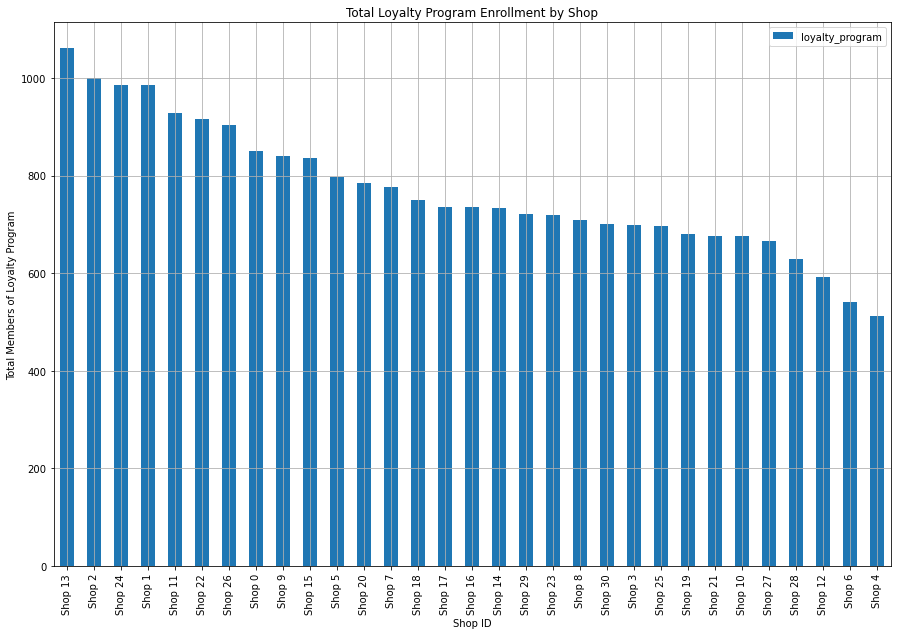

In [17]:
# Total loyalty program enrollment by Shop ID

loyalty_pivot.plot(kind = 'bar', x = 'shop_id', y = 'loyalty_program', figsize = (15,10), grid = True)
plt.title('Total Loyalty Program Enrollment by Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Members of Loyalty Program');

### Total Loyalty Program Enrollment Notes

After examining the above bar graph we can already prove the hypothesis "Shops with higher loyalty program utilizations will have higher sales" is incorrect as the 3 shops with highest loyalty program enrollment are Shop 13, 2, and 1 while the shops with highest sales (15,0,5) 8th (0), 10th (15) and 11th (5) in loyalty program enrollment.  

In [18]:
#total sales at each shop by loyalty program enrollment

loyalty_sales_pivot = retail_merge.pivot_table(
    index = 'shop_id',
    columns = 'loyalty_program',
    values = 'total_price',
    aggfunc = 'sum'
).reset_index().sort_values(1, ascending = False)

loyalty_sales_pivot.head()

loyalty_program,shop_id,0,1
22,Shop 29,14702.74,17358.78
26,Shop 5,47521.92,15573.87
19,Shop 26,17199.07,15093.34
23,Shop 3,16492.31,11842.56
24,Shop 30,22489.04,11317.89


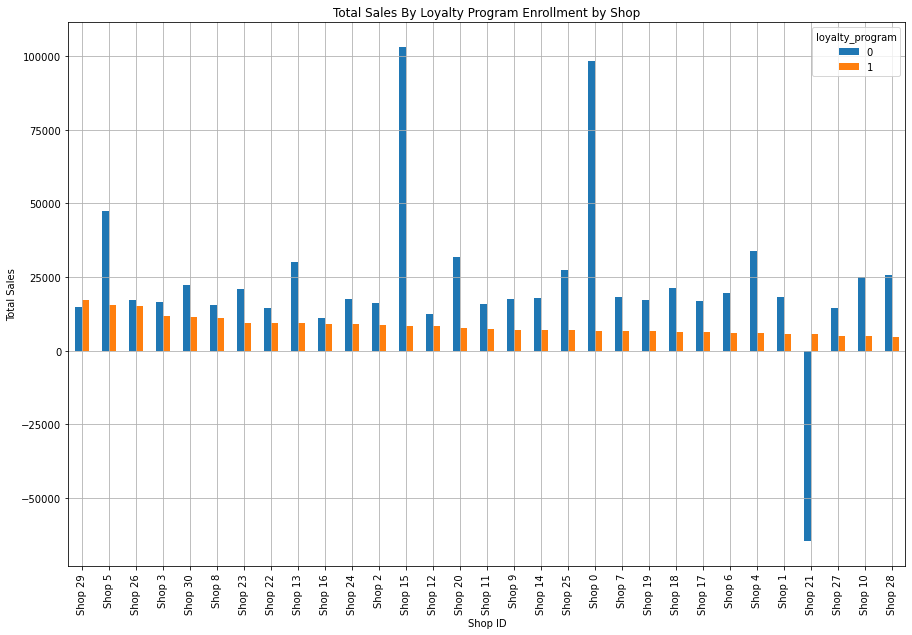

In [19]:
# Total sales by loyalty program enrollment by Shop ID

loyalty_sales_pivot.plot(kind = 'bar', x = 'shop_id', y = [0,1], figsize = (15,10), grid = True)
plt.title('Total Sales By Loyalty Program Enrollment by Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales');

### Total Sales by Loyalty Program Notes

We can see the three top shops by sales (0, 15, and 5) but also see how small of a portion of their sales are comprised by people in the loyalty program. Interestingly, 26, 29 and 8 are the shops with the most loyalty program sales with 29 actually having higher sales from loyalty program members than non-loyalty program members. Shop 5 is the only of the top 3 shops that has a significant portion of its sales come from loyalty_program members. 

In [20]:
# creating a purchase_month column

retail_merge['purchase_month'] = retail_merge['purchase_date'].astype('datetime64[M]')

retail_merge['purchase_month'].value_counts()

retail_merge['purchase_date'] = retail_merge['purchase_date'].dt.date

retail_merge['purchase_date'].value_counts()

2016-12-06    3878
2016-12-17    3115
2016-12-01    3108
2016-12-07    2963
2016-12-09    2891
              ... 
2017-01-16     646
2017-02-13     624
2016-12-19     522
2016-12-22     291
2017-02-06     279
Name: purchase_date, Length: 68, dtype: int64

In [21]:
# total sales by month pivot

date_pivot = retail_merge.pivot_table(
    index = 'purchase_month',
    values = 'total_price',
    aggfunc = 'sum'
).reset_index()

date_pivot

,purchase_month,total_price
0,2016-12-01,362182.45
1,2017-01-01,322105.72
2,2017-02-01,292762.58


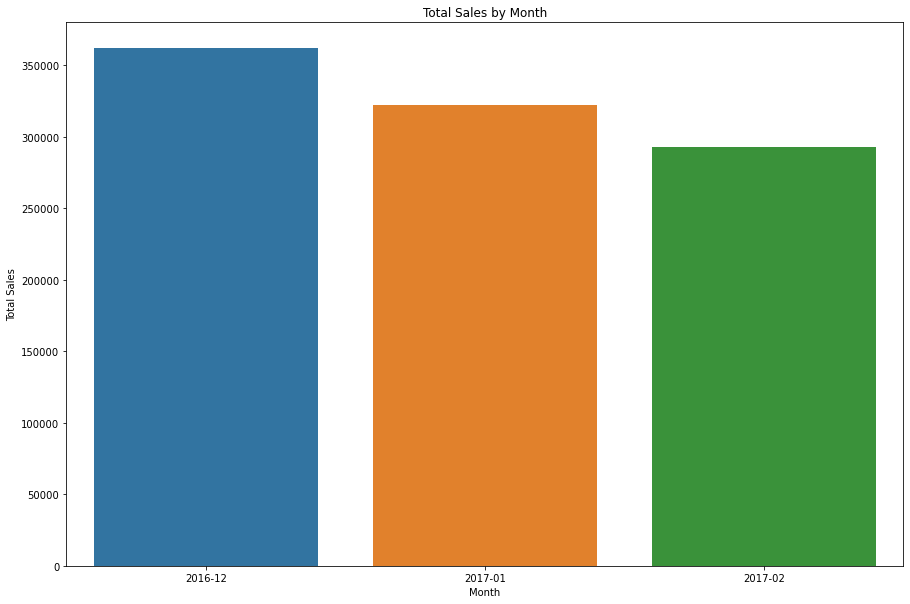

In [22]:
# graph total sales by month

plt.figure(figsize=(15, 10))  
sns.barplot(data = date_pivot, x = 'purchase_month', y = 'total_price')
plt.xticks([0,1,2], ['2016-12', '2017-01','2017-02'])
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales');

### Total Sales by Month Notes

We can see from the above graph that were was a 100K drop in sales between February 2017 and January 2017 but only a 250K increase between December 2016 and January 2017. The increase in sales in January coincides with post-winter holidays, it is possible customers were undertaking new building projects in the new year. 

## Hypotheses Testing

Now that EDA is finished I can move on to statistical testing. I will only be testing hypothesis 2 and 3 as hypothesis 1 was disproved during EDA. 


Hypothesis 1: Shops with higher loyalty program utilizations will have higher sales (**FALSE**)

Hypothesis 2:

**h0:** Customers who are part of the loyalty program DO NOT make more total purchases 

**h1:** Customers who are part of the loyalty program make more total purchases

Hypothesis 3:

**h0:** ustomers who are part of the loyalty program DO NOT have larger purchase totals

**h1:** Customers who are part of the loyalty program have larger purchase totals


In [23]:
# dropping all rows where `customer_id = 0 to allow for grouping data by unqiue customer purchases

retail_merge2 = retail_merge[retail_merge['customer_id'] != 0]

In [24]:
# create df for total purchases by unqiue customer_ids in loyalty program members

purchase_members = (
    retail_merge2[retail_merge2['loyalty_program'] == 1]
    .groupby('customer_id', as_index=False)
    .agg({'purchase_id': pd.Series.nunique})
)
    
purchase_members.columns = ['customer_id', 'purchases']
purchase_members.head()

,customer_id,purchases
0,22005,2
1,22006,2
2,22011,1
3,22012,3
4,22018,1


In [25]:
# create df for total purchases by unqiue customer_ids in non-loyalty program members

purchase_nonmembers = (
    retail_merge2[retail_merge2['loyalty_program'] == 0]
    .groupby('customer_id', as_index=False)
    .agg({'purchase_id': pd.Series.nunique})
)
    
purchase_nonmembers.columns = ['customer_id', 'purchases']
purchase_nonmembers.head()

,customer_id,purchases
0,18025,2
1,18026,2
2,18027,2
3,18029,1
4,18031,1


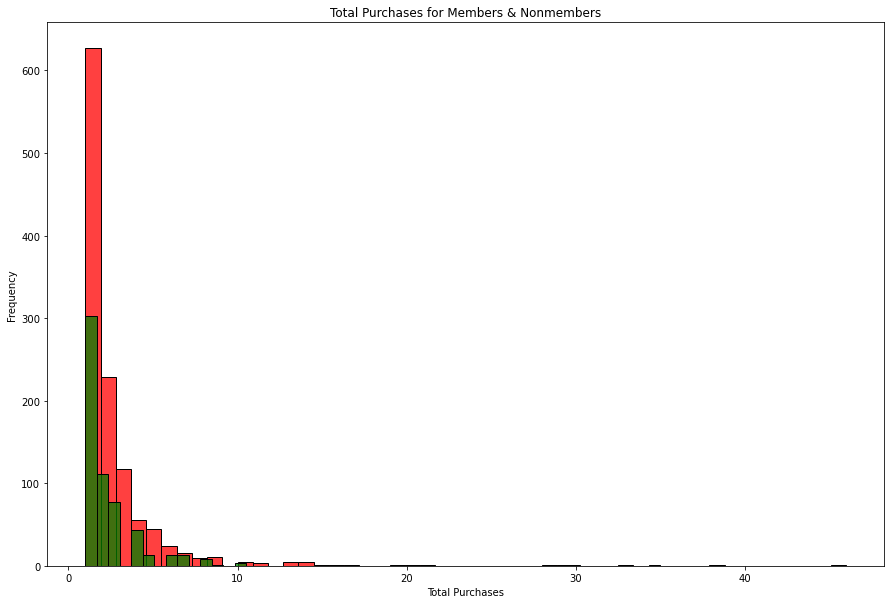

In [26]:
# graph distribution of total purchases in each group

plt.figure(figsize = (15,10))
sns.histplot(purchase_nonmembers['purchases'], bins = 50, color = 'red')
sns.histplot(purchase_members['purchases'], bins = 50, color = 'green')
plt.title('Total Purchases for Members & Nonmembers')
plt.ylabel('Frequency')
plt.xlabel('Total Purchases');

In [27]:
# drop outliers (>20 purchases)

purchase_members_norm = purchase_members[purchase_members['purchases'] < 20]
purchase_nonmembers_norm = purchase_nonmembers[purchase_nonmembers['purchases'] < 20]

In [28]:
#h0: Customers who are part of the loyalty program DO NOT make more total purchases
#h1: Customers who are part of the loyalty program make more total purchases

alpha = .05

results = st.mannwhitneyu(purchase_nonmembers_norm['purchases'], purchase_members_norm['purchases'], True, 'less')

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

p-value:  0.1514024124711114
Failed to reject the null hypothesis: we can't make conclusions about the difference


### Hypothesis 2 Notes

After running a statistical test on the total purchases made by customers not in the loyalty program and in the loyalty program we got the outcome "Failed to reject the null hypothesis" meaning that the hypothsis "Customers who are part of the loyalty program make more total purchases" is untrue and there is not a statistically significant difference between either groups.

In [29]:
# create df for total purchase size by unqiue customer_ids in loyalty program members

sales_members = (
    retail_merge2[retail_merge2['loyalty_program'] == 1]
    .groupby('customer_id', as_index=False)
    .agg({'total_price': pd.Series.sum})
)
    
sales_members.columns = ['customer_id', 'total_spent']
sales_members.sort_values('total_spent', ascending = False).head()

,customer_id,total_spent
537,23781,32524.57
350,23190,14981.22
336,23129,7511.90
97,22363,7027.62
26,22101,5610.69


In [30]:
# create df for total purchase size by unqiue customer_ids in non-loyalty program members

sales_nonmembers = (
    retail_merge2[retail_merge2['loyalty_program'] == 0]
    .groupby('customer_id', as_index=False)
    .agg({'total_price': pd.Series.sum})
)
    
sales_nonmembers.columns = ['customer_id', 'total_spent']
sales_nonmembers.sort_values('total_spent', ascending = False).head()

,customer_id,total_spent
701,20325,47418.71
544,19835,16955.23
24,18094,16510.13
1086,21708,15045.48
1001,21428,10235.45


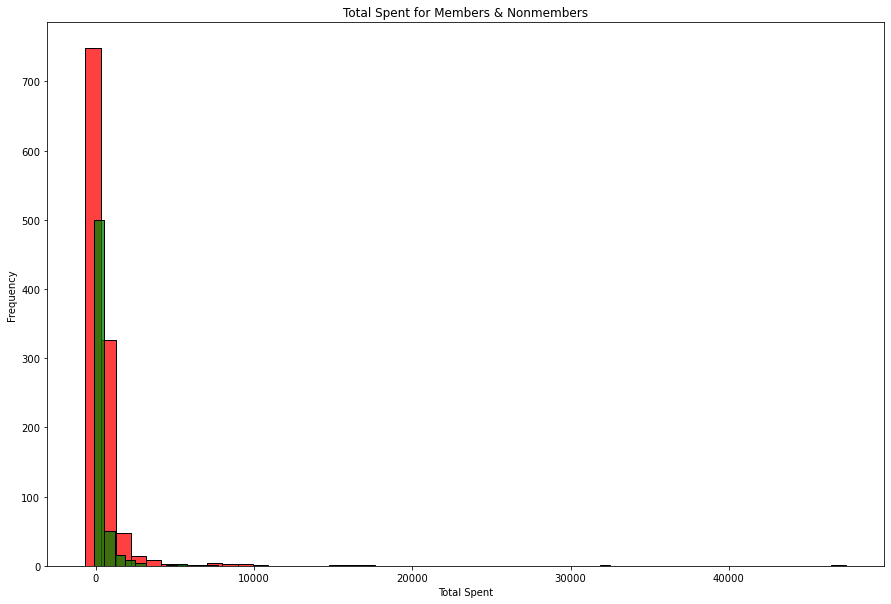

In [31]:
# check distribution of total purchase size in each group

plt.figure(figsize = (15,10))
sns.histplot(sales_nonmembers['total_spent'], bins = 50, color = 'red')
sns.histplot(sales_members['total_spent'], bins = 50, color = 'green')
plt.title('Total Spent for Members & Nonmembers')
plt.ylabel('Frequency')
plt.xlabel('Total Spent');

In [32]:
# drop outliers (>20,000 dollars)

sales_members_norm = sales_members[sales_members['total_spent'] < 20_000]
sales_nonmembers_norm = sales_nonmembers[sales_nonmembers['total_spent'] < 20_000]

In [33]:
# h0: ustomers who are part of the loyalty program DO NOT have larger purchase totals
# h1: Customers who are part of the loyalty program have larger purchase totals

alpha = .05

results = st.mannwhitneyu(sales_nonmembers_norm['total_spent'], sales_members_norm['total_spent'], True, 'less')

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

p-value:  0.9620616483393305
Failed to reject the null hypothesis: we can't make conclusions about the difference


### Hypothesis 3 Notes

After running a statistical test on the total spending by customers not in the loyalty program and in the loyalty program we got the outcome "Failed to reject the null hypothesis" meaning that the hypothsis "Customers who are part of the loyalty program have larger purchase totals" is untrue and there is not a statistically significant difference between either groups.

# Conclusion

The goal of this analysis is to "Assess the performance of the chain's sales outlets". To this end I have examined the data to determine which shops are highest and lowest in sales, how loyalty program enrollment is doing and its impact on sales at each shop, and how total sales have changed over the three months the data includes. I also ran statistical tests on the total purchases and total spent by loyalty program members vs non-loyalty program members to determine how the loyalty program impacted customer buy habits. Below are my findings:

Top 3 stores by sales: Shops 15, 0, and 5

Bottom 3 stores by sales: Shops 12, 16, and 21

Top 3 stores by loyalty program enrollment: Shops 13, 2, and 1

Bottom 3 stores by loyalty program enrollment: Shops 12, 6, and 4 

Top 3 shops by sales from loyalty program members: Shops 25, 5, and 26

Bottom 3 shops by sales from loyalty program members: Shops 27, 10, and 28

Sales over time: 25k increase between December and January, 10k drop between January and February

Returns: Shop 21 has nearly 80K recorded in returns, this should be investigated directly to determine the cause of this response. 

**Hypotheses**

Hypothesis 1: Shops with higher loyalty program utilizations will have higher sales **(FALSE)**

Hypothesis 2: Customers who are part of the loyalty program make more total purchases **(False)**

Hypothesis 3: Customers who are part of the loyalty program have larger purchase totals **(False)**

All three hypotheses were rejected in the course of my analysis which leads me to conclude that the loyalty program does not have a significant effect on customer buying habits. While that does not mean the loyalty program is entirely useless, it does not indicate it is a successful means on increasing total sales or incentives more purchases. I do not reccomend investing large amout of resources into that project.

**Recommendation**

Shops 15, 0 and 5 have dramatically higher sales than any other stores but only Shop 5 overlaps top sales with top sales among loyalty program members. Focusing on increasing sales in Shops 25 and 26 MAY prove extra effective given the already high loyalty program enrollment.  



# Documentation

- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html: referenced to order graphs by decreasing values

- https://seaborn.pydata.org/generated/seaborn.barplot.html: referenced for code structure

- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html: referenced to improve legibility of graphs

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html: referenced for code stucture and to confirm relevence

- https://medium.com/swlh/hypothesis-testing-in-data-science-afccd58b52da: referenced for guidance on statistical tests

- https://help.tableau.com/current/pro/desktop/en-us/calculations_calculatedfields_formulas.htm: referenced during tableau portion to help create new columns